In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from mda import MDAHead
import sys
import torch.nn.functional as F

In [2]:
# --- Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train = datasets.MNIST(".", train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(full_train, [.9, .1])

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1000, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transform),
    batch_size=1000, shuffle=False
)

In [3]:
class Net(nn.Module):
    def __init__(self, head='mda'):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 2)
        if head == 'mda': 
            self.head = MDAHead(d=2, num_classes=10, K=1)
        elif head == 'softmax':
            self.head = nn.Linear(2, 10)
        else:
            sys.exit('Unknown head.')

    def encode(self, X):
        x = X.view(-1, 28*28)
        h = torch.relu(self.fc1(x))
        return self.fc2(h)

    def forward(self, X):
        z = self.encode(X)
        return self.head(z)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(head='mda').to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return 100 * correct / total

In [6]:
best_val_acc = 0.0
best_path = "best.pt"

for epoch in range(10):
    model.train()
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        logits = model(X)
        loss_cls = criterion(logits, y)

        with torch.no_grad():
            x_flat = X.view(-1, 28*28)
            h1 = torch.relu(model.fc1(x_flat))
            z = model.fc2(h1)       # encoder output (2D)
            logpdf = model.head._component_logpdf(z)
            logpi  = F.log_softmax(model.head.logits_pi, -1)
            gamma  = (logpdf + logpi.unsqueeze(0))
            gamma  = (gamma - torch.logsumexp(gamma, dim=(1,2), keepdim=True)).exp()  # [B,C,K]
            Nk = gamma.sum(0).clamp_min(1e-4)                                         # [C,K]
            mu_hat = (gamma.permute(1,2,0) @ z) / Nk[...,None]                         # [C,K,D]

        loss_align = (model.head.mu - mu_hat).pow(2).mean()

        loss = loss_cls + 0.05 * loss_align
        loss.backward()
        opt.step()
    
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: train loss={loss.item():.4f} | val acc={val_acc:.2f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1: train loss=0.6419 | val acc=90.42
Epoch 2: train loss=0.3339 | val acc=91.98
Epoch 3: train loss=0.3026 | val acc=93.29
Epoch 4: train loss=0.7311 | val acc=93.33
Epoch 5: train loss=0.3124 | val acc=94.03
Epoch 6: train loss=0.1768 | val acc=94.13
Epoch 7: train loss=0.3080 | val acc=93.91
Epoch 8: train loss=0.2834 | val acc=93.68
Epoch 9: train loss=0.2117 | val acc=94.13
Epoch 10: train loss=0.4357 | val acc=94.53


In [7]:
# --- Evaluation ---
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 94.53%


In [8]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (head): MDAHead()
)

In [9]:
# collect a small random subset of embeddings
emb_list, y_list = [], []
max_points = int(len(train_loader.dataset) * 0.05)

with torch.no_grad():
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        x_flat = X.view(-1, 28*28)
        h1 = torch.relu(model.fc1(x_flat))
        z = model.fc2(h1)       # encoder output (2D)
        emb_list.append(z)
        y_list.append(y)
        if sum(t.shape[0] for t in emb_list) >= max_points:
            break

Z = torch.cat(emb_list, dim=0).cpu().numpy()[:max_points]
Y = torch.cat(y_list, dim=0).cpu().numpy()[:max_points]

In [10]:
mu = model.head.mu.detach().cpu()  # (C, K, D) or (C*K, D)

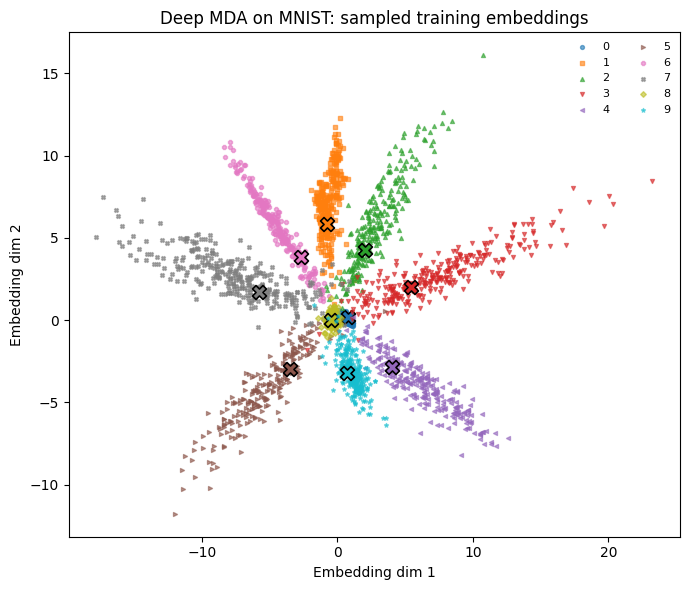

In [11]:
plt.figure(figsize=(7,6))
cmap = plt.get_cmap("tab10", 10)
markers = ['o','s','^','v','<','>','P','X','D','*']

for c in range(10):
    idx = (Y == c)
    plt.scatter(Z[idx,0], Z[idx,1], s=8, alpha=0.6,
                c=[cmap(c)], marker=markers[c], label=f"{c}")
    for k in range(mu.shape[1]):
        m = mu[c, k]
        plt.scatter(m[0], m[1], s=100, marker='X',
                    c=[cmap(c)], edgecolor='k', linewidths=1.2)
        #plt.text(m[0]-.1, m[1]-.5, f"{c}", fontsize=9, weight="bold")

plt.title("Deep MDA on MNIST: sampled training embeddings")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.legend(fontsize=8, ncol=2, frameon=False)
plt.tight_layout()
plt.show()